In [1]:
import brainsss
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import random
from scipy.stats import sem
import time
import h5py
import ants
import nibabel as nib
import matplotlib
import pickle
from shutil import copyfile
from mpl_toolkits.axes_grid1 import ImageGrid
from skimage.filters import threshold_otsu as otsu
from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import binary_dilation
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap

/home/users/brezovec/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning: Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function
  "Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function"


In [2]:
### ANDREW PIPELINE ###

warp_types = ['direct_affine', 'direct_syn', 'localmean_ANTS', 'localmean_synthmorph']

centroids = {}
for warp_type in warp_types:
    file = f"/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20221217_LC11_centroids/20221217_{warp_type}.npy"
    centroids[warp_type] = np.load(file, allow_pickle=True).item()

In [3]:
### also load subvol centroids
file = f"/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20221217_LC11_centroids/20221217_localmean_synthmorph_andrewpipeline_subvol.npy"
temp = np.load(file, allow_pickle=True).item()
centroids['localmean_synthmorph']['subvol'] = temp['subvol']

In [4]:
### delete 2 bad brains in other hemi
for warp_type in warp_types:
    del centroids[warp_type]['clandinin_flip'][6]
    del centroids[warp_type]['clandinin_flip'][2]

In [5]:
for warp_type in warp_types:
    for brain_type in ['clandinin', 'murthy']:
        centroids[warp_type][F'{brain_type}_comb'] = centroids[warp_type][F'{brain_type}'].copy()
        centroids[warp_type][F'{brain_type}_comb'].extend(centroids[warp_type][F'{brain_type}_flip'])

In [6]:
comparison_means_all = {}
comparison_std_all = {}
comparison_pairwise_diffs_all = {}

warp_types = ['localmean_synthmorph'] # remove this if comparing across types
warp_types = ['direct_affine', 'direct_syn', 'localmean_ANTS', 'localmean_synthmorph']


for warp_type in warp_types:

    comparisons = [('clandinin_comb', 'clandinin_comb'), #intra
                   ('murthy_comb', 'murthy_comb'),#intra
                   ('clandinin_comb', 'murthy_comb'),
                   ('clandinin', 'clandinin'),
                   ('clandinin_flip', 'clandinin_flip'),
                   ('clandinin', 'clandinin_flip'),
                   ('murthy', 'murthy'),
                   ('murthy_flip', 'murthy_flip'),
                   ('murthy', 'murthy_flip'),
                   ('clandinin', 'murthy'),
                   ('clandinin_flip', 'murthy_flip')]
                   #('clandinin', 'subvol'),
                   #('subvol', 'subvol')] #this only exists for synthmorph

    comparison_means = {}
    comparison_std = {}
    comparison_pairwise_diffs = {}
    
    for comparison in comparisons:
        
        brain_type_1 = comparison[0]
        brain_type_2 = comparison[1]

        pairwise_diffs = []
        
        for axis in [0,1,2]:
            
            a=[i[axis] for i in centroids[warp_type][brain_type_1]]
            b=[i[axis] for i in centroids[warp_type][brain_type_2]]

            ### if it is an intra comparison, skip comparisons of exact same brains
            if brain_type_1 == brain_type_2:
                pairwise_diff = [np.abs((x-y)*.76) for i,x in enumerate(a) for j,y in enumerate(a) if i != j]
            else:
                pairwise_diff = [np.abs((x-y)*.76) for x in a for y in b]
            pairwise_diffs.append(pairwise_diff)

        ### calculate distances given all 3 axes
        distances = (np.asarray(pairwise_diffs[0])**2 +
                 np.asarray(pairwise_diffs[1])**2 + 
                 np.asarray(pairwise_diffs[2])**2)**0.5

        comparison_means[comparison] = np.mean(distances)
        comparison_std[comparison] = np.std(distances)
        comparison_pairwise_diffs[comparison] = distances
        
    comparison_means_all[warp_type] = comparison_means
    comparison_std_all[warp_type] = comparison_std
    comparison_pairwise_diffs_all[warp_type] = comparison_pairwise_diffs

In [9]:
comparison_means_all['direct_affine']

{('clandinin', 'clandinin'): 6.957996099234219,
 ('clandinin', 'clandinin_flip'): 8.444730294435486,
 ('clandinin', 'murthy'): 11.397494273085108,
 ('clandinin_comb', 'clandinin_comb'): 7.785951172314059,
 ('clandinin_comb', 'murthy_comb'): 11.485470968542204,
 ('clandinin_flip', 'clandinin_flip'): 7.228965359800928,
 ('clandinin_flip', 'murthy_flip'): 10.92528935884663,
 ('murthy', 'murthy'): 9.499884417453277,
 ('murthy', 'murthy_flip'): 9.776332507379655,
 ('murthy_comb', 'murthy_comb'): 9.957280309750933,
 ('murthy_flip', 'murthy_flip'): 11.049668972471213}

In [ ]:
np.median()

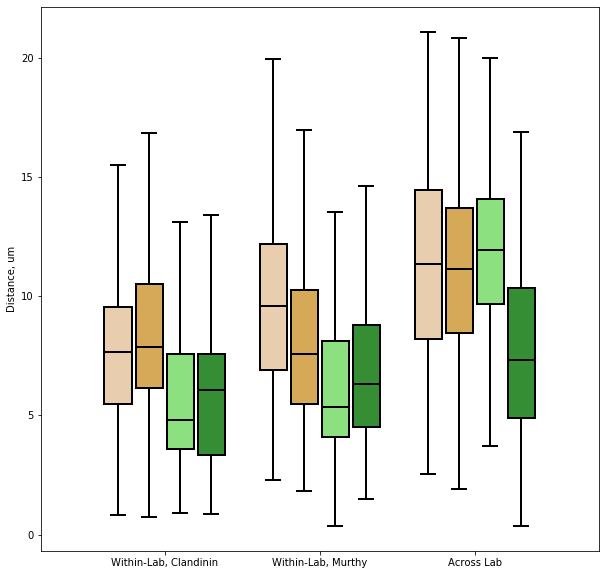

In [66]:
plt.figure(figsize=(10,10))
ax = plt.gca()
bar_width = 0.2
xs_ = [0,.2,.4,.6]
colors = ['#E8CDAF', "#D6A958", "#8DE080", "#358E33"]
labels = ['Direct Affine', 'Direct ANTs','Local Meanbrain', 'Full Pipeline (+synthmorph)']

# comp_to_plot = [('clandinin_comb', 'clandinin_comb'),
#                 ('murthy_comb', 'murthy_comb'),
#                 ('clandinin_comb', 'murthy_comb')]

# comp_to_plot = [('clandinin_flip', 'clandinin_flip'),
#                 ('murthy_flip', 'murthy_flip'),
#                 ('clandinin_flip', 'murthy_flip')]

comp_to_plot = [('clandinin_comb', 'clandinin_comb'),
                ('murthy_comb', 'murthy_comb'),
                ('clandinin_comb', 'murthy_comb')]

# comp_to_plot = [('clandinin', 'clandinin'),
#                 ('clandinin_flip', 'clandinin_flip'),
#                 ('clandinin', 'clandinin_flip')]

# comp_to_plot = [('murthy', 'murthy'),
#                 ('murthy_flip', 'murthy_flip'),
#                 ('murthy', 'murthy_flip')]

for j,comparsion in enumerate(comp_to_plot):
    xs = [i+j for i in xs_]
    group_values = []
    group_std = []
    for k,warp_type in enumerate(warp_types):
        bplot = ax.boxplot(comparison_pairwise_diffs_all[warp_type][comparsion],positions=[xs[k]],
                           showfliers=False,widths=.18,notch=False,patch_artist=True,
           medianprops={"linewidth": 2,"solid_capstyle": "butt","color":'k'},
           boxprops={"linewidth": 2,"color":'k'},
           capprops={"linewidth": 2,"color":'k'},
           whiskerprops={"linewidth": 2,"color":'k'})
        bplot['boxes'][0].set_facecolor(colors[k])
        
#         group_values.append(comparison_means_all[warp_type][comparsion])
#         n_samples = len(centroids[warp_type][comparsion[0]])
#         group_std.append(comparison_std_all[warp_type][comparison]/np.sqrt(n_samples))
#     plt.bar(xs,group_values,
#             yerr=group_std,
#             width=bar_width,
#             color=colors)

plt.ylabel('Distance, um')
plt.xticks([.3,1.3,2.3], ['Within-Lab, Clandinin', 'Within-Lab, Murthy', 'Across Lab'])

# ax = plt.gca()
# all_handles = []
# for i in range(len(colors)):
#     all_handles.append(mpatches.Patch(color=colors[i], label=labels[i]))
# leg = ax.legend(handles=all_handles)
# ax.add_artist(leg)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)

In [183]:
k

3

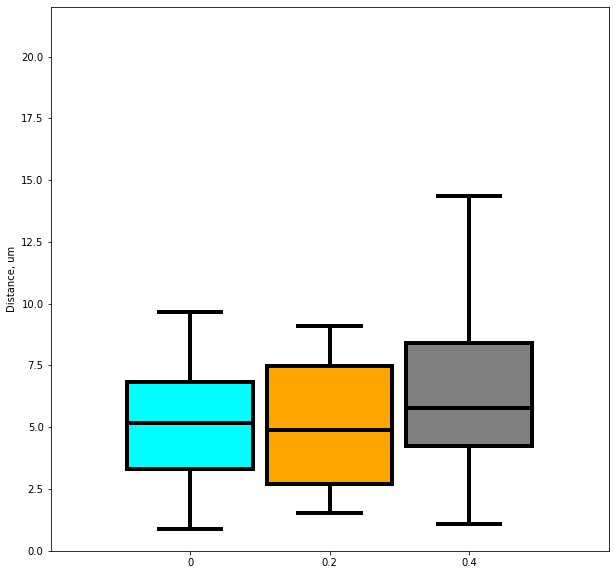

In [215]:
plt.figure(figsize=(10,10))
ax = plt.gca()
bar_width = 0.2
xs_ = [0,.2,.4]
colors = ['cyan', 'orange', 'grey']

comp_to_plot = [('clandinin', 'clandinin'),
                ('subvol', 'subvol'),
                ('clandinin', 'subvol')]

warp_type = 'localmean_synthmorph'

for j,comparsion in enumerate(comp_to_plot):

    bplot = ax.boxplot(comparison_pairwise_diffs_all[warp_type][comparsion],positions=[xs_[j]],
                       showfliers=False,widths=.18,notch=False,patch_artist=True,
       medianprops={"linewidth": 4,"solid_capstyle": "butt","color":'k'},
       boxprops={"linewidth": 4,"color":'k'},
       capprops={"linewidth": 4,"color":'k'},
       whiskerprops={"linewidth": 4,"color":'k'})
    bplot['boxes'][0].set_facecolor(colors[j])

plt.ylabel('Distance, um')
plt.xlim(-.2,.6)
plt.ylim(0,22)
#plt.xticks([.3,1.3,2.3], ['Within-Lab, Clandinin', 'Within-Lab, Murthy', 'Across Lab'])

# ax = plt.gca()
# all_handles = []
# for i in range(len(colors)):
#     all_handles.append(mpatches.Patch(color=colors[i], label=labels[i]))
# leg = ax.legend(handles=all_handles)
# ax.add_artist(leg)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)

# centroids quantify each axis

In [42]:
comparison_pairwise_diffs_all = {}

warp_types = ['localmean_synthmorph']

for warp_type in warp_types:

    comparisons = [('clandinin', 'clandinin'),
                   ('murthy', 'murthy'),
                   ('clandinin', 'murthy')]

    comparison_pairwise_diffs = {}
    
    for comparison in comparisons:
        
        brain_type_1 = comparison[0]
        brain_type_2 = comparison[1]

        pairwise_diffs = []
        
        for axis in [0,1,2]:
            
            a=[i[axis] for i in centroids[warp_type][brain_type_1]]
            b=[i[axis] for i in centroids[warp_type][brain_type_2]]

            ### if it is an intra comparison, skip comparisons of exact same brains
            if brain_type_1 == brain_type_2:
                pairwise_diff = [np.abs((x-y)*.76) for i,x in enumerate(a) for j,y in enumerate(a) if i != j]
            else:
                pairwise_diff = [np.abs((x-y)*.76) for x in a for y in b]
            pairwise_diffs.append(pairwise_diff)

        # save each axis separately
        distances = (np.asarray(pairwise_diffs[0]),
                     np.asarray(pairwise_diffs[1]), 
                     np.asarray(pairwise_diffs[2]))

        comparison_pairwise_diffs[comparison] = distances
    comparison_pairwise_diffs_all[warp_type] = comparison_pairwise_diffs

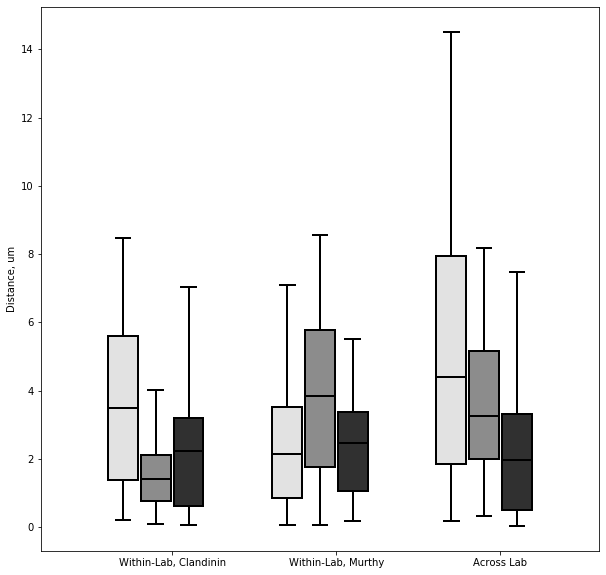

In [48]:
plt.figure(figsize=(10,10))
ax = plt.gca()
bar_width = 0.2
xs_ = [0,.2,.4,.6]
colors = ['#E2E2E2', "#8C8C8C", "#303030"]
labels = ['Direct Affine', 'Direct ANTs','Local Meanbrain', 'Full Pipeline (+synthmorph)']

comp_to_plot = [('clandinin', 'clandinin'),
                ('murthy', 'murthy'),
                ('clandinin', 'murthy')]

for j,comparsion in enumerate(comp_to_plot):
    xs = [i+j for i in xs_]
    group_values = []
    group_std = []
    for k,axis in enumerate([0,1,2]): #loop over axes instead of warptypes
        bplot = ax.boxplot(comparison_pairwise_diffs_all[warp_type][comparsion][axis],positions=[xs[k]],
                           showfliers=False,widths=.18,notch=False,patch_artist=True,
           medianprops={"linewidth": 2,"solid_capstyle": "butt","color":'k'},
           boxprops={"linewidth": 2,"color":'k'},
           capprops={"linewidth": 2,"color":'k'},
           whiskerprops={"linewidth": 2,"color":'k'})
        bplot['boxes'][0].set_facecolor(colors[k])

plt.ylabel('Distance, um')
plt.xticks([.3,1.3,2.3], ['Within-Lab, Clandinin', 'Within-Lab, Murthy', 'Across Lab'])

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)

# visualize

In [2]:
def binarize_image(data,scale,binarize):
    if binarize:
        threshold = otsu(data)*scale
        data_binarized = np.where(data>threshold, 1, 0)
        return data_binarized
    else:
        return data
    
def calc_centroid(binary_image):
    return scipy.ndimage.measurements.center_of_mass(binary_image)

def calc_centroid_alex(binary_image):
    return np.argwhere(binary_image==1).mean(0)
        
def plot_centroid(cx,cy,cz,axis,color='r',transpose=False):
    if axis==0:
        plt.scatter(cz,cy,color='k',linewidth=1.5)
        plt.scatter(cz,cy,color=color,linewidth=.5)
    elif axis==1:
        plt.scatter(cz,cx,color='k',linewidth=1.5)
        plt.scatter(cz,cx,color=color,linewidth=.5)
    elif axis==2:
        if transpose:
            plt.scatter(cx,cy,color='k',linewidth=1.5)
            plt.scatter(cx,cy,color=color,linewidth=.5)
        else:
            plt.scatter(cy,cx,color='k',linewidth=1.5)
            plt.scatter(cy,cx,color=color,linewidth=.5)
            
def draw_grid(vlines=5, hlines=5, lw=.5):
    for i in np.arange(0,vlines*20,20):
        plt.axvline(i,color='w',lw=lw)
    for i in np.arange(0,hlines*20,20):
        plt.axhline(i,color='w',lw=lw)
        
def clean_anat(brain):
    brain_copy = brain.copy().astype('float32')
    brain_copy = scipy.ndimage.filters.gaussian_filter(brain_copy, sigma=0.5)

    labels, label_nb = scipy.ndimage.label(brain_copy)
    brain_label = np.bincount(labels.flatten())[1:].argmax()+1

    brain_copy = np.where(labels==brain_label, 1.0, 0.0)

    return brain_copy*brain

In [196]:
20*.76

15.2

In [3]:
bbox = {'x_start': 200, 'x_end': 325, #125
        'y_start': 150, 'y_end': 225, #75
        'z_start': 40, 'z_end': 140} #100

In [4]:
##################
### load masks ###
##################

pvlp_mask = "/oak/stanford/groups/trc/data/Alex/ROI_masks/pvlp_and_plp.nii"
pvlp_mask = ants.image_read(pvlp_mask).numpy()
mask_eroded = binary_erosion(pvlp_mask, structure=np.ones((2,2,2)))
mask_dilated = binary_dilation(mask_eroded, iterations=2)
pvlp_mask_cropped = mask_dilated[bbox['x_start']:bbox['x_end'],
                               bbox['y_start']:bbox['y_end'],
                               bbox['z_start']:bbox['z_end']]

In [5]:
file = "/oak/stanford/groups/trc/data/Yukun/registration/mean_brain/FDA_downsampled_flip.nii"
FDA = ants.image_read(file)

In [6]:
########################
### ANDREWS PIPELINE ###
########################

### DEFINE DIRECTORIES ###
oak = "/oak/stanford/groups/trc/data/"
warp_types = ['direct_affine', 'direct_syn', 'localmean_ANTS', 'localmean_synthmorph']

directories_clandinin = {
     'direct_affine': "Brezovec/2P_Imaging/20221029_FDA_direct_affine/clandinin",
     'direct_syn': "Brezovec/2P_Imaging/20221029_FDA_direct_syn/clandinin",
     'localmean_ANTS': "Alex/clab_data/LC11/func/aligned_to_FDA/",
     'localmean_synthmorph': "Alex/clab_data/LC11/func/synthmorph_to_FDA"
}

for warp_type in warp_types:
    directories_clandinin[warp_type] = os.path.join(oak, directories_clandinin[warp_type])
    
directories_murthy = {
     'direct_affine': "Brezovec/2P_Imaging/20221029_FDA_direct_affine/murthy",
     'direct_syn': "Brezovec/2P_Imaging/20221029_FDA_direct_syn/murthy",
     'localmean_ANTS': "Alex/albert_data/LC11/func/aligned_to_FDA/",
     'localmean_synthmorph': "Alex/albert_data/LC11/func/synthmorph_to_FDA"
}
    
for warp_type in warp_types:
    directories_murthy[warp_type] = os.path.join(oak, directories_murthy[warp_type])
    

In [27]:
###########################################
### Load warped indiv LC11 gloms in FDA ###
###########################################

######################################
### HERE IS KEY VARIABLE TO CHANGE ###
warp_type = 'localmean_ANTS'#'localmean_synthmorph'
######################################

brains = {}
brains_cropped = {}
#brain_types = ['clandinin', 'murthy', 'clandinin_flip', 'murthy_flip', 'connectome']
brain_types = ['clandinin','murthy']
for brain_type in brain_types:
    if 'clandinin' in brain_type:
        dir_ = directories_clandinin[warp_type]
    elif 'murthy' in brain_type:
        dir_ = directories_murthy[warp_type]
    elif 'connectome' in brain_type:
        LC11_fda_path = "/oak/stanford/groups/trc/data/Alex/clab_data/LC11/LC11_FDA_ds_flip.nii"
        LC11_fda = ants.image_read(LC11_fda_path)[:]
        LC11_fda_cropped = LC11_fda[bbox['x_start']:bbox['x_end'],
                           bbox['y_start']:bbox['y_end'],
                           bbox['z_start']:bbox['z_end']]
        brains[brain_type] = [LC11_fda]
        brains_cropped[brain_type] = [LC11_fda_cropped]
        continue
    elif 'subvol' in brain_type:
        brains[brain_type] = []
        dir_ = '/oak/stanford/groups/trc/data/Alex/clab_data/LC11_subvol/func/synthmorph_to_FDA'
        files = [x for x in os.listdir(dir_) if '_o_' in x]
        for file in files:
            print(file)
            to_load = os.path.join(dir_,file)
            image = ants.image_read(to_load)
            ### these vols are still cropped down, so put in full FDA space
            xr = 89; yr = 89; zr = 39
            xc = 265; yc = 165; zc = 155
            full_vol = np.zeros(FDA.shape)
            full_vol[xc-xr:xc+xr,yc-yr:yc+yr,zc-zr:zc+zr] = image.numpy()
            full_vol = full_vol[:,:,::-1]
            brains[brain_type].append(full_vol)
        continue
        
    brains[brain_type] = []
    files = [x for x in os.listdir(dir_) if 'green' in x] 
    #files = [x for x in os.listdir(dir_)] ### use this for localmean_synthmorph
    for file in files:
        if '210216_02' in file:
            continue
        print(file)
        to_load = os.path.join(dir_,file)
        image = ants.image_read(to_load)
        
        if 'flip' in brain_type:
            image = image[::-1,:,:]
        
        brains[brain_type].append(image)

210208_03_green_registered.nii
210208_02_green_registered.nii
210223_03_green_registered.nii
210223_04_green_registered.nii
210218_02_green_registered.nii
210223_01_green_registered.nii
210216_04_green_registered.nii
210223_02_green_registered.nii
220426_LC11_vol2_local_atlas_green_registered.nii
220413_LC11_vol1_local_atlas_green_registered.nii
220425_LC11_vol1_local_atlas_green_registered.nii
220420_LC11_vol1_local_atlas_green_registered.nii
220420_LC11_vol2_local_atlas_green_registered.nii
220412_LC11_vol1_local_atlas_green_registered.nii
220419_LC11_vol2_local_atlas_green_registered.nii
220426_LC11_vol1_local_atlas_green_registered.nii


In [28]:
for brain_type in brain_types:
    brains_cropped[brain_type] = []
    for i in range(len(brains[brain_type])):
        ### crop to bounding box
        brains_cropped[brain_type].append(brains[brain_type][i][bbox['x_start']:bbox['x_end'],
                   bbox['y_start']:bbox['y_end'],
                   bbox['z_start']:bbox['z_end']])

In [13]:
bbox = {'x_start': 200, 'x_end': 325, #125
        'y_start': 150, 'y_end': 225, #75
        'z_start': 40, 'z_end': 140} #100

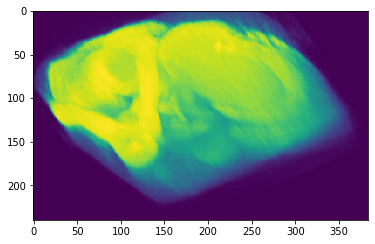

In [27]:
plt.imshow(np.max(FDA[200:325,:,:],axis=0).T)

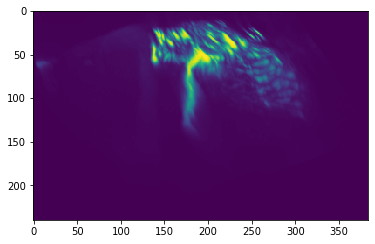

In [22]:
plt.imshow(np.max(brains['clandinin'][0][200:325,:,:],axis=0).T)

In [28]:
brains['clandinin'][0].shape

(826, 384, 240)

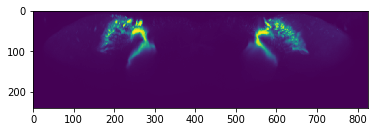

In [23]:
plt.imshow(np.max(brains['clandinin'][0][:,150:225,:],axis=1).T)

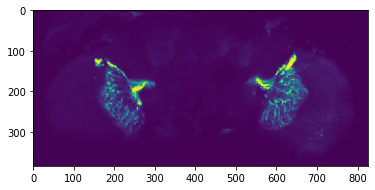

In [21]:
plt.imshow(np.max(brains['clandinin'][0][:,:,40:140],axis=2).T)

In [ ]:
plt.imshow(np.max(brains['clandinin'][0][:,:,40:140],axis=2).T)

In [29]:
########################################################
### Generate normalized mean images of green channel -      CROPPED
########################################################

meanbrains_cropped = {}
for brain_type in brain_types:
    meanbrain = np.zeros(brains_cropped[brain_type][0].shape)
    for i in range(len(brains_cropped[brain_type])):
        max_value = np.max(brains_cropped[brain_type][i])
        if max_value == 0:
            max_value = 1            
        meanbrain += brains_cropped[brain_type][i]/max_value
    meanbrains_cropped[brain_type] = meanbrain

In [13]:
###########################
### calculate centroids ###
###########################

thresh_scales = {'clandinin': [1,1,1,1,1,1,1,1,1],
                 #'murthy': [2,2,2,1.5,1.5,1.5,1.5,1.5],
                 'murthy': [1.5,1.3,1,1,1.2,1,1.5,1.3],
                 'clandinin_flip': [1,1,1,1,1,1,2,1,1],
                 'murthy_flip': [1.5,2,2,2,1.5,1,1,2],
                 'connectome':[1],
                 'subvol': [1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5],
                 'subvol_flip': [1,1,1,1,1,1,2,1,1]}

centroids = {}
for brain_type in ['clandinin','murthy','subvol']:
    centroids[brain_type] = []
    for i in range(len(brains_cropped[brain_type])):
        try:
            binary_image = binarize_image(brains_cropped[brain_type][i],thresh_scales[brain_type][i],binarize=True)
        except:
            continue

        binary_image*=pvlp_mask_cropped
        binary_image = clean_anat(binary_image)
        cx,cy,cz = calc_centroid(binary_image)
        centroids[brain_type].append((cx,cy,cz))

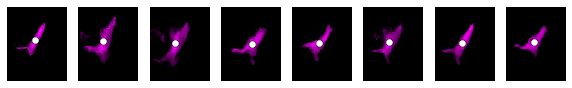

In [285]:
########################################
### visually confirm good thresholds ###
########################################

plt.figure(figsize=(10,3))
binarize=True
brain_type = 'murthy'
for i in range(len(brains_cropped[brain_type])):
    axis=1
    plt.subplot(1,8,i+1)
    binary_image = binarize_image(brains_cropped[brain_type][i],thresh_scales[brain_type][i],binarize)
    binary_image*=pvlp_mask_cropped
    binary_image = clean_anat(binary_image)
    cmap = LinearSegmentedColormap.from_list('mycmap', ['black', 'magenta'])
    plt.imshow(np.mean(binary_image,axis=axis),cmap=cmap)
    #draw_grid(lw=1)
    plt.axis('off')
    cx,cy,cz = calc_centroid(binary_image)
    #plot_centroid(cx,cy,cz,axis,color='w')
    plot_centroid(cx,cy,cz,axis,color='w')

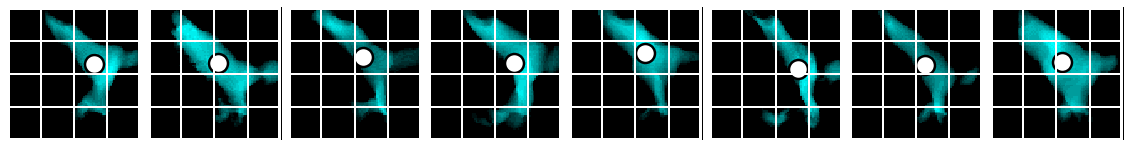

In [71]:


def plot_centroid(cx,cy,cz,axis,color='r',transpose=False):
    if axis==0:
        plt.scatter(cz,cy,color='k',linewidth=1.5)
        plt.scatter(cz,cy,color=color,linewidth=.5)
    elif axis==1:
        plt.scatter(cz,cx,color='k',linewidth=15.5)
        plt.scatter(cz,cx,color=color,linewidth=10.5)
    elif axis==2:
        if transpose:
            plt.scatter(cx,cy,color='k',linewidth=1.5)
            plt.scatter(cx,cy,color=color,linewidth=.5)
        else:
            plt.scatter(cy,cx,color='k',linewidth=1.5)
            plt.scatter(cy,cx,color=color,linewidth=.5)

def draw_grid(vlines=5, hlines=5, lw=.5):
    for i in np.arange(0,vlines*20,20):
        plt.axvline(i,color='w',lw=lw)
    for i in np.arange(0,hlines*20,20):
        plt.axhline(i,color='w',lw=lw)
            
########################################
### visually confirm good thresholds ###
########################################

plt.figure(figsize=(20,10))
binarize=True
brain_type = 'clandinin'
for i in range(8):#range(len(brains_cropped[brain_type])):
    axis=1
    plt.subplot(1,8,i+1)
    binary_image = binarize_image(brains_cropped[brain_type][i],thresh_scales[brain_type][i],binarize)
    binary_image*=pvlp_mask_cropped
    binary_image = clean_anat(binary_image)
    cmap = LinearSegmentedColormap.from_list('mycmap', ['black', 'cyan'])
    binary_image = binary_image.T[::-1,:] ### for horizontal graphs
    #binary_image = binary_image[::-1,:,::-1] ### for vertical graphs
    plt.imshow(np.mean(binary_image,axis=axis),cmap=cmap)
    draw_grid(lw=2)
    plt.axvline(20,color='w',lw=6)
    plt.axhline(20,color='w',lw=6)
    plt.axvline(100,color='w',lw=6)
    plt.axhline(100,color='w',lw=6)
    plt.axis('off')
    
    cx,cy,cz = calc_centroid(binary_image)
    #plot_centroid(cx,cy,cz,axis,color='w')
    plot_centroid(cx,cy,cz,axis,color='w')
    plt.xlim(20,100)
    plt.ylim(100,20)
    
#     ax = plt.gca()
#     r = Affine2D().rotate_deg(90)
#     for x in ax.images + ax.lines + ax.collections:
#         trans = x.get_transform()
#         x.set_transform(r+trans)
#         if isinstance(x, PathCollection):
#             transoff = x.get_offset_transform()
#             x._transOffset = r+transoff
#     old = ax.axis()
#     ax.axis(old[2:4] + old[0:2])
#     plt.show()
    
plt.subplots_adjust(wspace=0.05)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)

In [52]:
binary_image.shape

(125, 75, 100)

In [28]:
ax._transOffset

AttributeError: 'AxesSubplot' object has no attribute '_transOffset'

In [20]:
from matplotlib.transforms import Affine2D
from matplotlib.collections import PathCollection

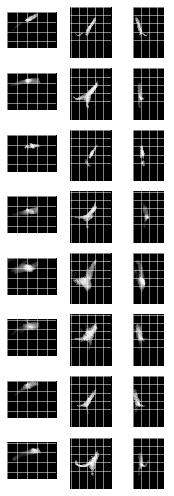

In [219]:
########################################
### visually confirm good thresholds ###
########################################

plt.figure(figsize=(3,10))
binarize=True
brain_type = 'murthy'
for i in range(len(brains_cropped[brain_type])):
    for axis in [0,1,2]:
        plt.subplot(9,3,(3*i+axis)+1)
        binary_image = binarize_image(brains_cropped[brain_type][i],thresh_scales[brain_type][i],binarize)
        binary_image*=pvlp_mask_cropped
        binary_image = clean_anat(binary_image)
        plt.imshow(np.mean(binary_image,axis=axis),cmap='Greys_r')
        draw_grid()
        plt.axis('off')
        cx,cy,cz = calc_centroid(binary_image)
        #plot_centroid(cx,cy,cz,axis)

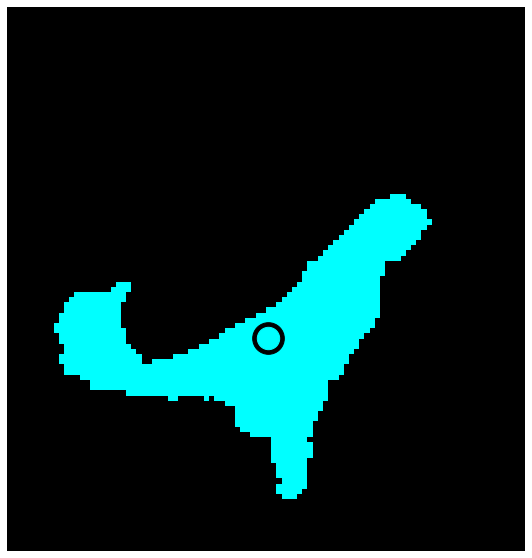

In [27]:
plt.figure(figsize=(10,10))
binarize=True
brain_type = 'clandinin'
i=5
axis=1
binary_image = binarize_image(brains_cropped[brain_type][i],thresh_scales[brain_type][i],binarize)
binary_image*=pvlp_mask_cropped
binary_image = clean_anat(binary_image)
cmap = LinearSegmentedColormap.from_list('mycmap', ['black', 'cyan'])
plt.imshow(np.max(binary_image,axis=axis)[:-20,:],cmap=cmap)
#draw_grid()
plt.axis('off')
cx,cy,cz = calc_centroid(binary_image)
plot_centroid(cx,cy,cz,axis,color='cyan')

# save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
# timestr = time.strftime("%Y%m%d-%H%M%S")
# fname = os.path.join(save_path, f'{timestr}')
# plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)

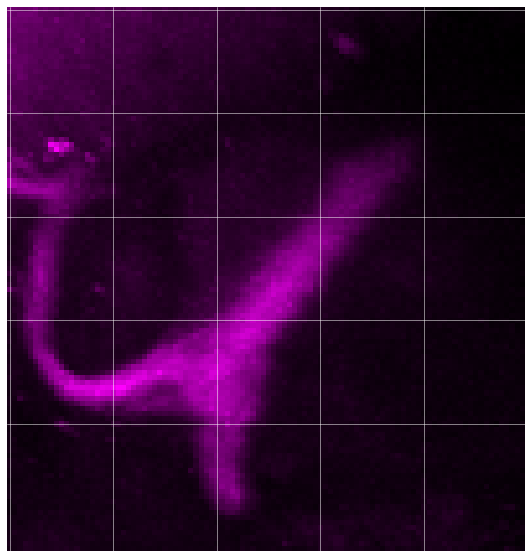

In [35]:
plt.figure(figsize=(10,10))
binarize=False
brain_type = 'murthy'
i=1
axis=1
binary_image = binarize_image(brains_cropped[brain_type][i],thresh_scales[brain_type][i],binarize)
#binary_image*=pvlp_mask_cropped
#binary_image = clean_anat(binary_image)
cmap = LinearSegmentedColormap.from_list('mycmap', ['black', 'magenta'])
plt.imshow(np.max(binary_image,axis=axis)[:-20,:],cmap=cmap)#,vmax=2000)
draw_grid()
plt.axis('off')
cx,cy,cz = calc_centroid(binary_image)
#plot_centroid(cx,cy,cz,axis,color='magenta')

# save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
# timestr = time.strftime("%Y%m%d-%H%M%S")
# fname = os.path.join(save_path, f'{timestr}')
# plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)

In [ ]:
plt.figure(figsize=(10,10))
binarize=False
brain_type = 'clandinin'
i=5
axis=1
binary_image = binarize_image(brains_cropped[brain_type][i],thresh_scales[brain_type][i],binarize)
#binary_image*=pvlp_mask_cropped
#binary_image = clean_anat(binary_image)
cmap = LinearSegmentedColormap.from_list('mycmap', ['black', 'cyan'])
plt.imshow(np.max(binary_image,axis=axis)[:-20,:],cmap=cmap,vmax=6000)
#draw_grid()
plt.axis('off')
cx,cy,cz = calc_centroid(binary_image)
#plot_centroid(cx,cy,cz,axis)

# look at single raw anat

In [77]:
## clandinin
anat = ants.image_read("/oak/stanford/groups/trc/data/Alex/clab_data/LC11/anat/raw/210208_03_red.nii").numpy()
func = ants.image_read("/oak/stanford/groups/trc/data/Alex/clab_data/LC11/func/raw/210208_03_green.nii").numpy()

In [175]:
# murthy
anat = ants.image_read("/oak/stanford/groups/trc/data/Alex/albert_data/LC11/anat/raw/220426_LC11_vol1_local_atlas_red.nii").numpy()
func = ants.image_read("/oak/stanford/groups/trc/data/Alex/albert_data/LC11/func/raw/220426_LC11_vol1_local_atlas_green.nii").numpy()

#220426_LC11_vol1_local_atlas_green-to-FDA.nii

In [125]:
os.listdir("/oak/stanford/groups/trc/data/Alex/albert_data/LC11/func/raw/")

['220412_LC11_vol1_local_atlas_green.nii',
 '220425_LC11_vol1_local_atlas_green.nii',
 '220420_LC11_vol2_local_atlas_green.nii',
 '220420_LC11_vol1_local_atlas_green.nii',
 '220413_LC11_vol1_local_atlas_green.nii',
 '220426_LC11_vol1_local_atlas_green.nii',
 '220426_LC11_vol2_local_atlas_green.nii',
 '220419_LC11_vol2_local_atlas_green.nii']

In [214]:
cmap = LinearSegmentedColormap.from_list('mycmap', ['k', 'magenta'])
temp = np.max(func[:,:,50:140],axis=2).T
out = cmap(NormalizeData(temp))
ids = np.where(temp<1500)
out[ids[0],ids[1],3] = 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


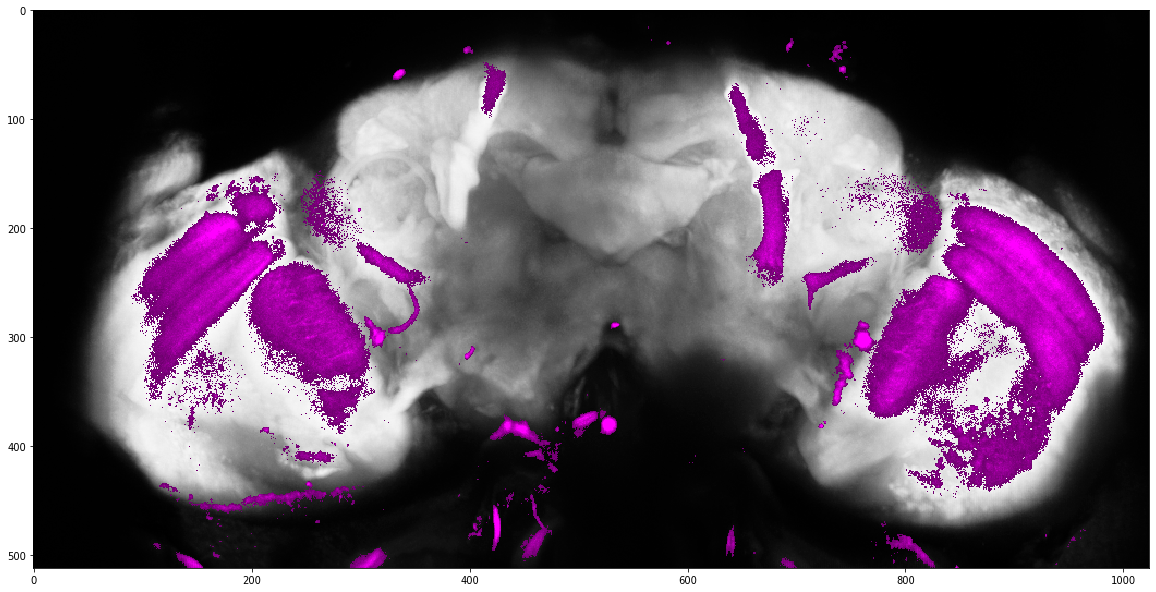

In [218]:
plt.figure(figsize=(20,20))
plt.imshow(np.max(anat[:,:,80:140],axis=2).T,cmap='Greys_r')
#plt.imshow(np.max(func[:,:,70:130],axis=2).T,cmap=cmap)#,vmax=2500)

plt.imshow(out*2.6)#,vmax=8000)
# plt.xlim(270,370)
# plt.ylim(310,210)

In [22]:
# tight crop for visualizing in figures
x_start = 30
x_stop = 110
y_start = 5
y_stop = 50
z_start = 0
z_stop = 80

In [24]:
### OG USE THIS ###

def make_overlay(axis):
    image1 = meanbrains_cropped['clandinin']*pvlp_mask_cropped
    image2 = meanbrains_cropped['murthy']*pvlp_mask_cropped

    image1 = image1[x_start:x_stop,y_start:y_stop,z_start:z_stop]
    image2 = image2[x_start:x_stop,y_start:y_stop,z_start:z_stop]

    image1 = np.max(image1,axis=axis)
    image2 = np.max(image2,axis=axis)

    image1 = NormalizeData(image1)
    image2 = NormalizeData(image2)

    cmap = LinearSegmentedColormap.from_list('mycmap', ['black', 'cyan'])
    rgba1 = cmap(image1)/2
    cmap = LinearSegmentedColormap.from_list('mycmap', ['black', 'magenta'])
    rgba2 = cmap(image2)

    merge = rgba1+rgba2/2
    merge = NormalizeData(merge)*2
    return merge

def plot_centroid(cx,cy,cz,axis,color='r',transpose=False):
    s1 = 800; s2 = 400
    if axis==0:
        plt.scatter(cy,80-cz,color='k',s=s1)
        plt.scatter(cy,80-cz,color=color,s=s2)
    elif axis==1:
        plt.scatter(cx,80-cz,color='k',s=s1)
        plt.scatter(cx,80-cz,color=color,s=s2)
    elif axis==2:
        if transpose:
            plt.scatter(cx,cy,color='k',s=s1)
            plt.scatter(cx,cy,color=color,s=s2)
        else:
            plt.scatter(cy,cx,color='k',s=s1)
            plt.scatter(cy,cx,color=color,s=s2)

def plot_all_centroids(axis,transpose=False):
    for i in range(len(centroids[warp_type]['clandinin'])):
        cx,cy,cz = centroids[warp_type]['clandinin'][i]
        plot_centroid(cx-x_start,cy-y_start,cz-z_start,axis,color='cyan',transpose=transpose)
    for i in range(len(centroids[warp_type]['murthy'])):
        cx,cy,cz = centroids[warp_type]['murthy'][i]
        plot_centroid(cx-x_start,cy-y_start,cz-z_start,axis,color='magenta',transpose=transpose)
        
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [154]:
#bottom left has y and z
# upper r has cx, cy
#so cy is AP axis

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


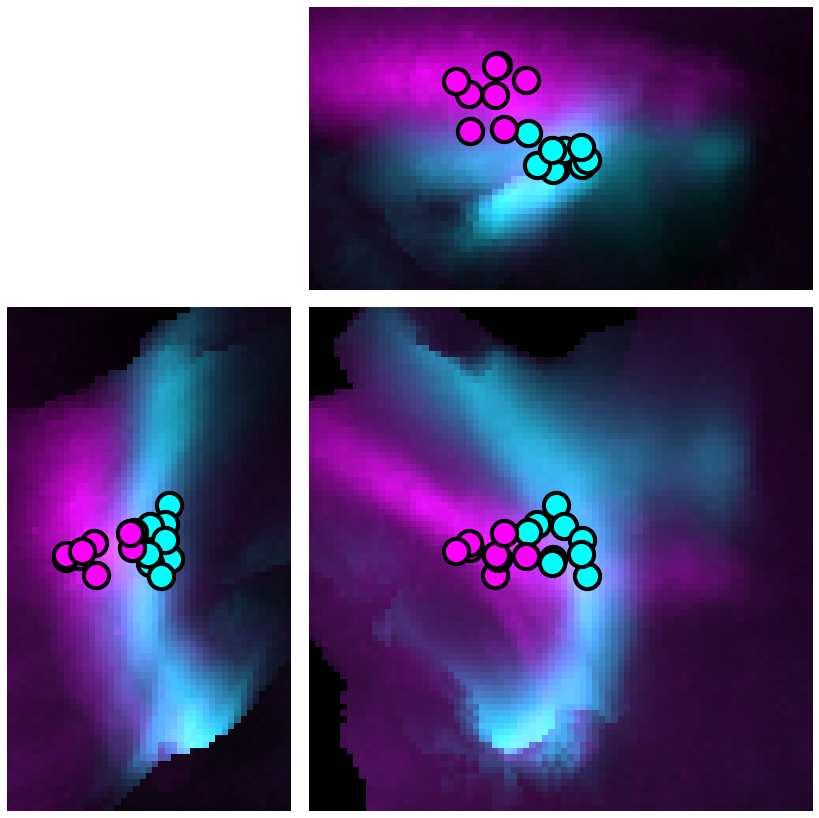

In [30]:
warp_types = ['direct_affine', 'direct_syn', 'localmean_ANTS', 'localmean_synthmorph']

warp_type = 'direct_affine'#
warp_type = 'localmean_synthmorph'
warp_type = 'localmean_ANTS'

fig = plt.figure(figsize=(10,10))

### BOTTOM LEFT ###
fig.add_axes([-.572,-.4,1,.7])
axis = 0
merge = make_overlay(axis)
plt.imshow(np.swapaxes(merge,0,1)[::-1])
plot_all_centroids(axis)
plt.axis('off')

### TOP RIGHT ###
fig.add_axes([0.15,.02,.7,1])
axis = 2
merge = make_overlay(axis)
plt.imshow(np.swapaxes(merge,0,1))
plot_all_centroids(axis,transpose=True)
plt.axis('off')

### BOTTOM RIGHT ###
fig.add_axes([0,-.4,1,.7])
axis = 1
merge = make_overlay(axis)
plt.imshow(np.swapaxes(merge,0,1)[::-1])
plot_all_centroids(axis)
plt.axis('off')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)

In [ ]:
# murthy has smaller centroid value for AP axis